Here, we summarise the results of the tests on real EMCCD images. Unlike the simulated image tests -- which used both over- and undersampled synthetic images -- all real images are in the oversampled regime.

In [31]:
# imports
import numpy as np
from astropy.stats import mad_std
from scipy.stats import norm
from astropy.stats import mad_std
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
#out_pd = np.vstack((MFBs_pd, MFVs_pd, Ps_normalised_pd, np.array(norm_phot_resids_pd).flatten(),
#                         image_SNRs_pd, image_FWHMs_pd, stamp_ids_pd, ll_pds)).T

#PyTorch_data = np.genfromtxt('PyTorchDIA_OGLE_BLG101_betterLnL.txt')
#pyDANDIA_data = np.genfromtxt('pyDANDIA_OGLE_BLG101_betterLnL.txt')
#flux_fraction = np.genfromtxt('Flux_fraction.txt')

pd_data = np.genfromtxt('pyDANDIA_OGLE_BLG101_December2020_TestRun.txt')
pt_data = np.genfromtxt('PyTorchDIA_OGLE_BLG101_December_2020_TestRun.txt')
print(pd_data.shape, pt_data.shape)

(28785, 8) (28785, 8)


In [12]:
# if NaNs are present, remove these
# NaNs from PyTorchDIA
pd_data = pd_data[~np.isnan(pt_data).any(axis=1)]
pt_data = pt_data[~np.isnan(pt_data).any(axis=1)]
print(pd_data.shape, pt_data.shape)
# NaNs from pyDANDIA / B08
pt_data = pd_data[~np.isnan(pd_data).any(axis=1)]
pd_data = pt_data[~np.isnan(pd_data).any(axis=1)]
print(pd_data.shape, pt_data.shape)

(28726, 8) (28726, 8)
(28726, 8) (28726, 8)


First, let's have a look at the log-likelihoods for both approaches. As the B08/pyDANDIA approach uses sigma-clipping to remove outlying pixels -- in contrast to PyTorchDIA, which uses all the data by optimising a robust loss function -- in order to compare the two likelihoods, we need to ensure we limit the comparison to cases in which no data has been rejected from the B08 solution.

In [30]:
# identify subset of stamps in which no data was rejected
pd_lls, pt_lls = pd_data[:,7], pt_data[:,7]
ndr = np.where(pd_lls != 0)[0] # no-data-rejected
pd_lls, pt_lls = pd_lls[ndr], pt_lls[ndr]

array([47951212.61478196, 47950529.41825257, 47948913.02409336, ...,
       47948070.60921583, 47948769.62317146, 47948997.40708014])

OK, let's move on to the other metrics. As with the simulated images results notebook, we'll use pandas in combination with seaborn to plot the metrics separated into SNR categories, and gain some insight into the distribution of each of the metrics and the correlations between them.

In [34]:
def numpy_to_DataFrame(array):
    
    # out = np.vstack((MFBs, MFVs, Ps_normalised, np.array(norm_phot_resids).flatten(),
    #                 image_SNRs, image_FWHMs, stamp_ids, ll)).T
    
    df = pd.DataFrame(array, columns=['MFB', 'MFV', '$P$',
                                      '$\mathcal{F}_{\mathrm{measured}}/\sigma_{\mathrm{min}}$',
                                      '$\mathrm{SNR}_{I}$',
                                      '$\mathrm{FWHM}_{I}$',
                                      'Stamp ID', 'log-likelihood'])


    
    # categories
    # SNR: 3 categories
    # 8 < $\mathrm{SNR}_{I}$ < 40, 40 < $\mathrm{SNR}_{I}$ < 200, 200 < $\mathrm{SNR}_{I}$ < 1000
    cat1, cat2, cat3 = '8 < $\mathrm{SNR}_{I}$ < 40', '40 < $\mathrm{SNR}_{I}$ < 200', '200 < $\mathrm{SNR}_{I}$ < 1280'

    df['SNR category'] = 0
    df['SNR category'][(8. < df['$\mathrm{SNR}_{I}$']) & (df['$\mathrm{SNR}_{I}$'] < 40.)] = cat1
    df['SNR category'][(40. < df['$\mathrm{SNR}_{I}$']) & (df['$\mathrm{SNR}_{I}$'] < 200.)] = cat2
    df['SNR category'][(200. < df['$\mathrm{SNR}_{I}$'])] = cat3
    
    df = df[df['SNR category']!= 0]
    
    # remove variable source (stamp 1)
    df = df[df['Stamp ID'] != 1.0]

    
    # set to categorical type
    df['SNR category'] = df['SNR category'].astype('category')
    
    #print(max(df['$\mathrm{SNR}_{I}$']))
    #plt.hist(df['$\mathrm{SNR}_{I}$'])
    #plt.show()
    
    ## drop unecessary columns
    df = pd.DataFrame.drop(df, columns=['$\mathrm{FWHM}_{I}$', '$\mathrm{SNR}_{I}$',
                                        'Stamp ID', 'log-likelihood'])
    
    # rearrange columns in correct order
    cols = df.columns.to_list()
    cols = [cols[2], cols[0], cols[1], cols[3], cols[4]]     
    df = df[cols]
    
    ## metrics by SNR category
    cats = [cat1, cat2, cat3]
    
    output_metrics = np.array([])
    
    for cat in cats:
        print('\n')
        print(cat)
        print('$P$:', np.median(df['$P$'][df['SNR category'] == cat]))
        N_set = len(df['$\mathcal{F}_{\mathrm{measured}}/\sigma_{\mathrm{min}}$'][df['SNR category'] == cat])
        print('MFB:', np.median(df['MFB'][df['SNR category'] == cat]))
        print('MFV:', np.median(df['MFV'][df['SNR category'] == cat]))
        nr = df['$\mathcal{F}_{\mathrm{measured}}/\sigma_{\mathrm{min}}$'][df['SNR category'] == cat]
        # remove bad outliers
        sigma = mad_std(nr)
        nr = nr[nr < np.nanmedian(nr) + 5*sigma]
        nr = nr[nr > np.nanmedian(nr) - 5*sigma]
        MPB = np.mean(nr)
        MPV = np.std(nr, ddof=1)**2
        print('N_set:', N_set)
        print('MPB:', MPB)
        print('MPV:', MPV)
        print('MedPB:', np.median(df['$\mathcal{F}_{\mathrm{measured}}/\sigma_{\mathrm{min}}$'][df['SNR category'] == cat]))
        sigmad = mad_std(df['$\mathcal{F}_{\mathrm{measured}}/\sigma_{\mathrm{min}}$'][df['SNR category'] == cat])
        print('MedPV:', sigmad**2)
        
        output_metrics = np.append(output_metrics, [np.median(df['$P$'][df['SNR category'] == cat]),
                                                   np.median(df['MFB'][df['SNR category'] == cat]),
                                                   np.median(df['MFV'][df['SNR category'] == cat]),
                                                   MPB, MPV])
        
    return df, output_metrics

print('pyDANDIA')
pyDANDIA_df, pyDANDIA_metrics = numpy_to_DataFrame(pd_data)
print('\nPyTorch')
PyTorch_df, PyTorch_metrics = numpy_to_DataFrame(pt_data)

pyDANDIA


8 < $\mathrm{SNR}_{I}$ < 40
$P$: 1.035333492594711
MFB: -0.00021897789696871317
MFV: 1.1525269178724509
N_set: 33
MPB: 3.023929356399811
MPV: 5.218436416886087
MedPB: 3.2597763538360596
MedPV: 7.004666970333998


40 < $\mathrm{SNR}_{I}$ < 200
$P$: 0.9965527737384935
MFB: 0.00036789607166897977
MFV: 1.2275823094074663
N_set: 10707
MPB: -1.352327559442237
MPV: 10.670803442127653
MedPB: -0.9867349863052368
MedPV: 7.170826723342531


200 < $\mathrm{SNR}_{I}$ < 1280
$P$: 1.0012615744955449
MFB: 0.0015265355850856274
MFV: 1.3955704086812752
N_set: 17912
MPB: -1.2298012994689715
MPV: 18.75716327631658
MedPB: -0.8125172555446625
MedPV: 11.283048232201626

PyTorch


8 < $\mathrm{SNR}_{I}$ < 40
$P$: 0.9520687314843795
MFB: 0.09281603967050663
MFV: 1.1744958727581738
N_set: 33
MPB: 2.6331594067089483
MPV: 3.778281792820538
MedPB: 2.3919425010681152
MedPV: 4.42110616298831


40 < $\mathrm{SNR}_{I}$ < 200
$P$: 1.0025375778542347
MFB: 0.08066227522189529
MFV: 1.2395255355846226
N_set: 107

/home/jah94/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


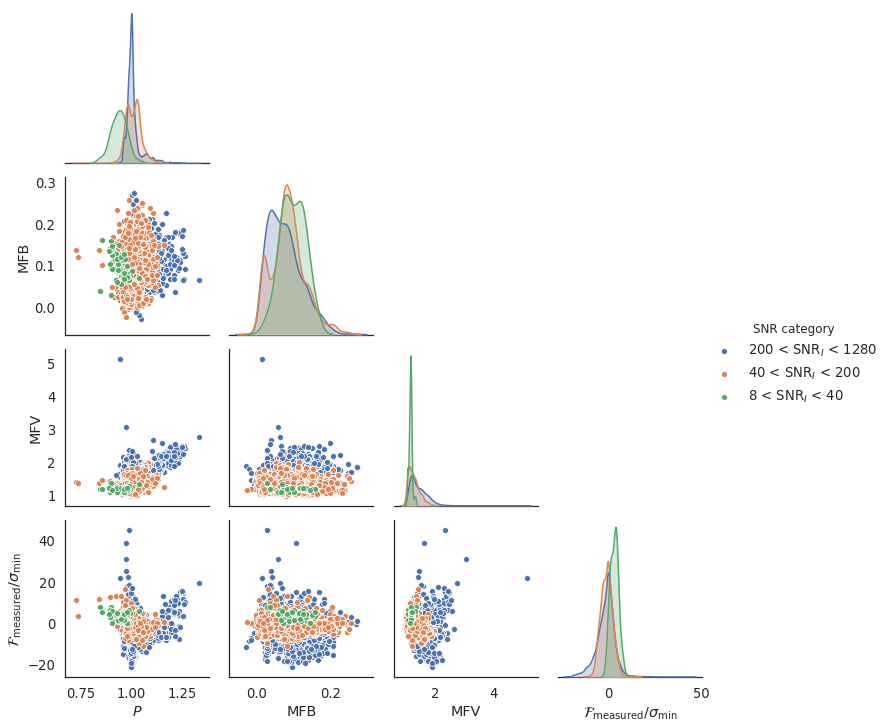

In [24]:
sns.set(context='notebook', font_scale = 1.2, style='white')
sns.pairplot(PyTorch_df, hue='SNR category', corner=True)
#plt.savefig('Corner_plot_PyTorch_real_data_.png')
#plt.show()

#sns.set(context='notebook', font_scale = 1.2, style='white')
#sns.pairplot(pyDANDIA_df, hue='SNR category', corner=True)
#plt.show()

In [25]:
# for clarity when plotting, exclude bad outliers
def clip(df):
    
    labels = ['$P$', 'MFB', 'MFV', '$\mathcal{F}_{\mathrm{measured}}/\sigma_{\mathrm{min}}$']
    
    for label in labels:
        column = df[label]
        std = mad_std(column)
        sigma = 5
        column[column > np.median(column) + sigma*std] = 0
        column[column < np.median(column) - sigma*std] = 0
        
        #if label == '$\mathcal{F}_{\mathrm{measured}}/\sigma_{\mathrm{min}}$':
        #    print('MPB:', np.mean(column))
        #    print('MPV:', (np.std(column))**2)
          
    clipped_df = df[df != 0]
    
    return clipped_df
        
PyTorch_df_clipped = clip(PyTorch_df)

/home/jah94/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


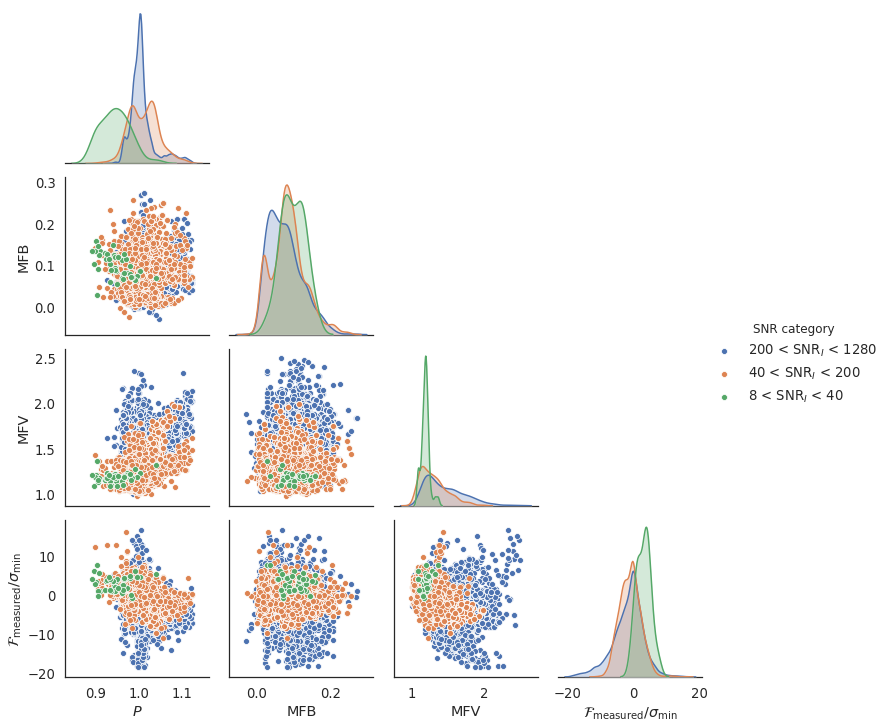

In [28]:
### cut outliers from plots for clarity
sns.set(context='notebook', font_scale = 1.2, style='white')
pp = sns.pairplot(PyTorch_df_clipped, hue='SNR category', corner=True)
#pp.axes[1,0].set_ylim(-0.2,0.2)
#pp.axes[3,1].set_xlim(-0.2,0.2)
#pp.axes[2,0].set_ylim(0.8, 3.5)
#pp.axes[3,2].set_xlim(0.8, 3.5)
#pp.axes[3,0].set_xlim(0.8, 1.35)
#pp.axes[3,1].tick_params(labelsize=10)
#pp.axes[4,2].tick_params(labelsize=12)
plt.savefig('Corner_plot_PyTorch_real_data_.png', bbox_inches='tight')

In [27]:
#### difference column for paper ####
diff = np.abs(pyDANDIA_metrics - PyTorch_metrics)
for d in diff:
    print(d)

0.08493926162391519
0.09693166264063124
0.03231976628652666
0.46109124602273477
1.3638833117255267
4.430679674505278e-05
0.0835869201631436
0.02167717064252872
0.18831555469037287
0.3878046416025498
0.0028498170827843117
0.07025339845636011
0.014392540889522909
0.24004998831363
1.4754386040628127
